In [ ]:
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

device: cpu


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return Categorical(logits=x)

In [ ]:
env = gym.make('CartPole-v1')
print('Environment:', 'CartPole-v1')
print('\t','action space:', env.action_space)
print('\t','observation space:', env.observation_space)

Environment: CartPole-v1
	 action space: Discrete(2)
	 observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
policy = Policy().to(device)
state = env.reset()
state = torch.from_numpy(state).float().to(device)
dist = policy(state)
action = dist.sample()

print("Sampled action: ", action.item())
print("Log probability of action: ", dist.log_prob(action).item())

Sampled action:  1
Log probability of action:  -0.5799687504768372


In [ ]:
def compute_returns(rewards, gamma):
    returns = 0
    for step in range(len(rewards)):
        returns += gamma**step * rewards[step]
    return returns

In [ ]:
learning_rate = 0.01
number_episodes = 1500
max_episode_length = 1000
gamma = 0.99

In [ ]:
def reinforce(env, seed, verbose=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.seed(seed)

    # instantiate the policy and optimizer
    policy = Policy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    scores = []
    scores_deque = deque(maxlen=100)
    for episode in range(1, number_episodes+1):
        log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_episode_length):
            dist = policy(torch.from_numpy(state).float().to(device))


            action = dist.sample()


            log_prob = dist.log_prob(action).unsqueeze(0)


            state, reward, done, _ = env.step(action.item())

            rewards.append(reward)
            log_probs.append(log_prob)

            if done:
                break

        # for reporting save the score
        scores.append(sum(rewards))
        scores_deque.append(sum(rewards))

        # calculate the discounted return of the trajectory
        returns = compute_returns(rewards, gamma)

        log_probs = torch.cat(log_probs)
        #  multiply the log probabilities by the returns and sum
        policy_loss = -torch.sum(log_probs*returns)


        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # report the score to check that we're making progress
        if episode % 50 == 0 and verbose:
            print('Episode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))

        if np.mean(scores_deque) >= 495.0 and verbose:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))
            break

    return policy, scores

In [ ]:
env = gym.make('CartPole-v1')
policy, scores = reinforce(env ,42)

In [ ]:
env_1 = gym.make('CartPole-v1')
state = env_1.reset()
for t in range(2000):
    dist = policy(torch.from_numpy(state).float().to(device))
    action = dist.sample()
    env_1.render()
    state, reward, done, _ = env_1.step(action.item())
    if done:
        break
env_1.close()
del env_1

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores)+1)
ax.plot(x, scores, label='Score')
m_average = moving_average(scores, 50)
ax.plot(x, m_average, label='Moving Average (w=100)', linestyle='--')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('REINFORCE learning curve - CartPole-v1')
plt.show()

In [ ]:
env = gym.make('CartPole-v1')
np.random.seed(53)
seeds = np.random.randint(1000, size=5)
all_scores = []
for seed in seeds:
    print("started training with seed: ", seed)
    _, scores = reinforce(env, int(seed), verbose=False)
    print("completed training with seed: ", seed)
    all_scores.append(scores)

started training with seed:  537
completed training with seed:  537
started training with seed:  797
completed training with seed:  797
started training with seed:  885
completed training with seed:  885
started training with seed:  421
completed training with seed:  421
started training with seed:  763
completed training with seed:  763


In [ ]:
smoothed_scores = [moving_average(s, 50) for s in all_scores]
smoothed_scores = np.array(smoothed_scores)
mean = smoothed_scores.mean(axis=0)
std = smoothed_scores.std(axis=0)

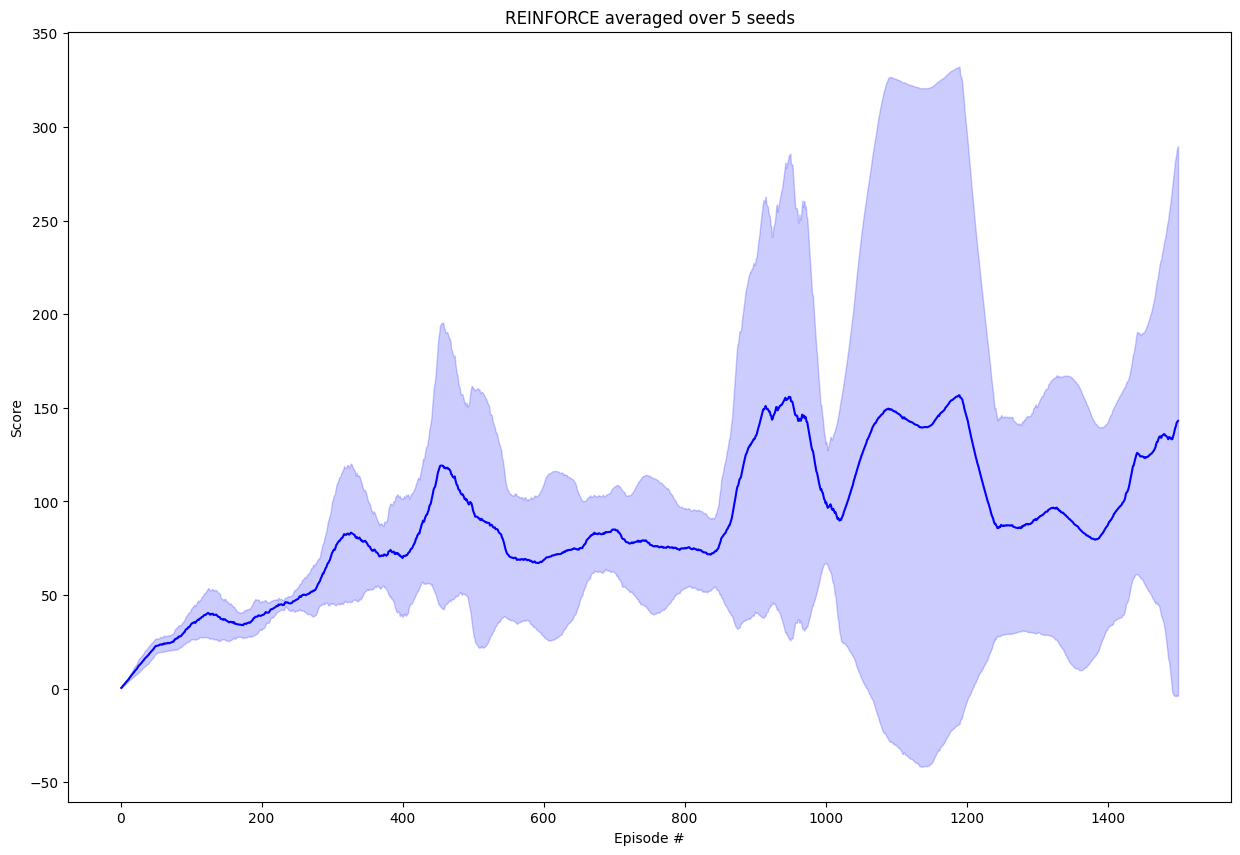

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(mean)+1)
ax.plot(x, mean, '-', color='blue')
ax.fill_between(x, mean - std, mean + std, color='blue', alpha=0.2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('REINFORCE averaged over 5 seeds')
plt.show()